In [847]:
from scipy.io import arff
from scipy import signal

import numpy as np
import sklearn as sk
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

%matplotlib inline

In [5]:
data = arff.loadarff('tecator.arff')

In [15]:
df_data = pd.DataFrame(data[0])

In [27]:
df_data

,absorbance_1,absorbance_2,absorbance_3,absorbance_4,absorbance_5,absorbance_6,absorbance_7,absorbance_8,absorbance_9,absorbance_10,...,principal_component_16,principal_component_17,principal_component_18,principal_component_19,principal_component_20,principal_component_21,principal_component_22,moisture,fat,protein
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,0.233876,0.899661,-0.042006,0.708717,-0.254173,-0.391579,-0.419313,60.5,22.5,16.7
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,-0.195980,-0.046359,-0.634996,-0.354403,0.014650,0.269542,0.096692,46.0,40.1,13.5
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,0.795466,0.762246,-1.268580,0.690588,-0.785592,-0.671237,-0.710290,71.0,8.4,20.5
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,0.616500,-0.388684,-2.068390,1.276160,-0.259437,-0.140206,-0.165963,72.8,5.9,20.7
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,-1.095540,-1.348450,0.453559,0.402624,0.031307,0.021824,0.145777,58.3,25.5,15.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3.22518,3.23016,3.23505,3.23988,3.24476,3.24971,3.25472,3.25980,3.26498,3.27041,...,-0.897510,-1.094940,-0.047774,-1.072080,0.683963,0.743673,0.824097,70.0,6.6,23.2
236,3.30792,3.31259,3.31733,3.32205,3.32683,3.33169,3.33663,3.34170,3.34700,3.35242,...,-1.033330,-1.196250,0.991593,-0.987896,0.813800,0.919915,0.950013,69.7,7.1,23.2
237,2.66103,2.66344,2.66582,2.66820,2.67065,2.67321,2.67588,2.67864,2.68160,2.68481,...,0.413767,0.500473,-0.232210,0.160583,-0.456995,-0.425684,-0.438117,69.1,7.7,22.9
238,3.02438,3.02997,3.03550,3.04102,3.04653,3.05209,3.05769,3.06330,3.06903,3.07484,...,-0.250646,-0.298301,-0.223632,-0.436276,0.372878,0.288446,0.383060,66.3,10.4,22.4


In [730]:
n_samples = 215
ab_array = df_data.iloc[:n_samples,:100].to_numpy()

pc_array = df_data.iloc[:n_samples,100:122].to_numpy()

pro_array = df_data.iloc[:n_samples,-1].to_numpy()
fat_array = df_data.iloc[:n_samples,-2].to_numpy()
wat_array = df_data.iloc[:n_samples,-3].to_numpy()

[Text(1, 0.0, 'low'), Text(1, 1.0, 'high')]

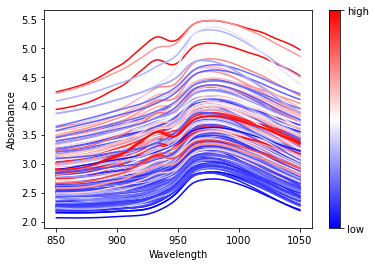

In [731]:
#colormap (blue: low fat, red: high fat)
cm_fat = plt.cm.bwr((fat_array-np.min(fat_array))/(np.max(fat_array)-np.min(fat_array)))
cm_wat = plt.cm.bwr((wat_array-np.min(wat_array))/(np.max(wat_array)-np.min(wat_array)))
cm_pro = plt.cm.bwr((pro_array-np.min(pro_array))/(np.max(pro_array)-np.min(pro_array)))

X = np.linspace(850,1050,100)

fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(cm_fat))
ax.set_xlabel('Wavelength')
ax.set_ylabel('Absorbance')

for i in range(n_samples):
    ax.plot(X, ab_array[i])

sm = plt.cm.ScalarMappable(cmap='bwr')
sm.set_array([])
  
cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 2))
cbar.ax.set_yticklabels(['low', 'high'])

# Répartitions des données % gras

(array([68., 42., 29., 19., 14.]),
 array([ 0.9 , 10.54, 20.18, 29.82, 39.46, 49.1 ]),
 <BarContainer object of 5 artists>)

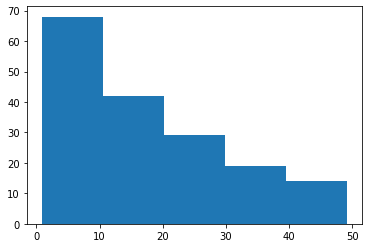

In [741]:
plt.hist(fat_array[:172], bins=5)

## Principal componenta VS fat

[Text(1, 0.0, 'low'), Text(1, 1.0, 'high')]

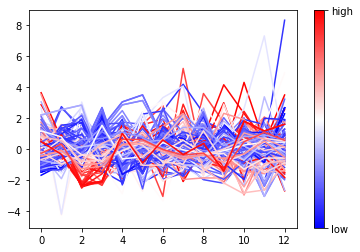

In [734]:
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(cm_fat))

for i in range(n_samples):
    ax.plot(range(len(pc_array[i][:13])),pc_array[i][:13])

sm = plt.cm.ScalarMappable(cmap='bwr')
sm.set_array([])
  
cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 2))
cbar.ax.set_yticklabels(['low', 'high'])

## absorbance spectrum - mean value

In [514]:
ab_tare_array = ab_array - (ab_array[:,:].mean(axis=1)).reshape(n_samples,1)

[Text(1, 0.0, 'low'), Text(1, 1.0, 'high')]

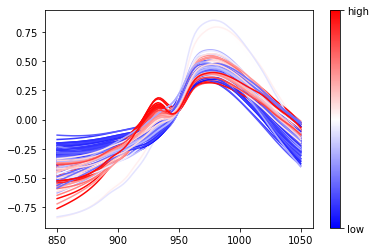

In [515]:
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(cm_fat))

for i in range(n_samples):
    ax.plot(X, ab_tare_array[i])

sm = plt.cm.ScalarMappable(cmap='bwr')
sm.set_array([])
  
cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 2))
cbar.ax.set_yticklabels(['low', 'high'])

outliers indices =  (array([ 33,  34, 139]),)


Text(0, 0.5, 'Absorbance at 980 nm')

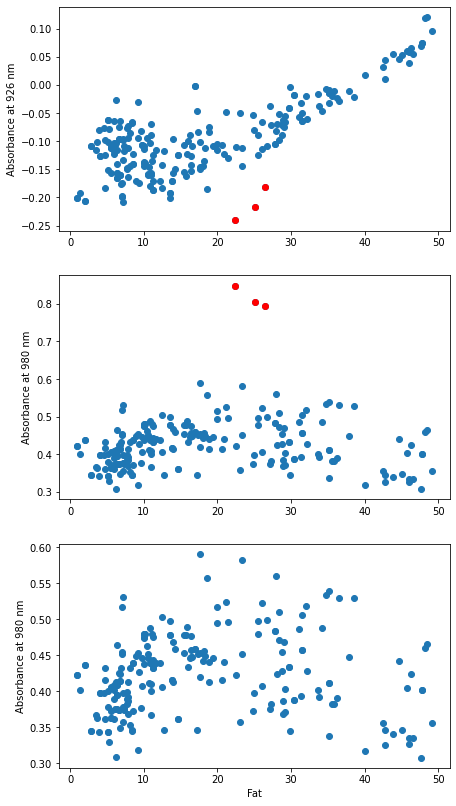

In [516]:
fig, ax = plt.subplots(3,1, figsize = (7,14))
ax[0].scatter(fat_array,ab_tare_array[:,38])
ax[1].scatter(fat_array,ab_tare_array[:,65])
# remove "outliers"
out_inds = ab_tare_array[:,65]>0.7
ax[2].scatter(fat_array[out_inds==0],ab_tare_array[:,65][out_inds==0])

print("outliers indices = ", np.where(out_inds))

ax[0].scatter(fat_array[out_inds],ab_tare_array[:,38][out_inds], c='red')
ax[1].scatter(fat_array[out_inds],ab_tare_array[:,65][out_inds], c='red')

ax[2].set_xlabel('Fat')
ax[0].set_ylabel(f'Absorbance at {850+38*2} nm')
ax[1].set_ylabel(f'Absorbance at {850+65*2} nm')
ax[2].set_ylabel(f'Absorbance at {850+65*2} nm')

## Derivatives

### First order

In [1203]:
dab_array = np.gradient(ab_array, axis=1)

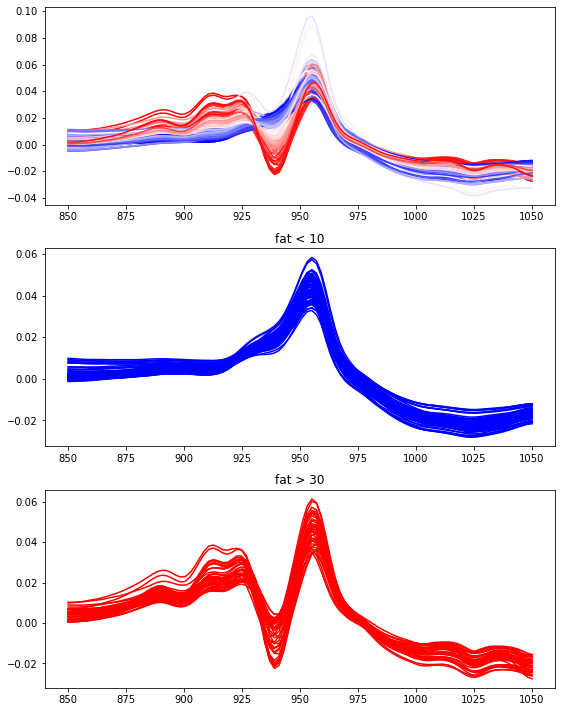

In [1222]:
fig, ax = plt.subplots(3,1, figsize=(8,10))
ax[0].set_prop_cycle('color', list(cm_fat))

for i in range(n_samples):
    ax[0].plot(X, dab_array[i])

for i in np.where(fat_array<10)[0]:
    ax[1].plot(X, dab_array[i], c='b')
    ax[1].set_title('fat < 10')

for i in np.where(fat_array>=30)[0]:
    ax[2].plot(X, dab_array[i], c='r')
    ax[2].set_title('fat > 30')
plt.tight_layout()

Text(0, 0.5, 'dA/dl at 950 nm')

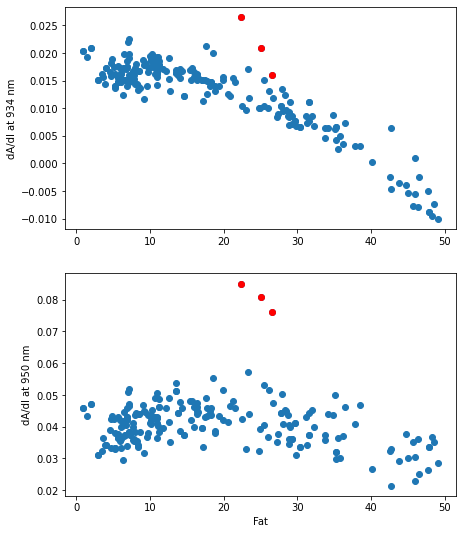

In [519]:
fig, ax = plt.subplots(2,1, figsize = (7,9))
ax[0].scatter(fat_array,dab_array[:,42])
ax[1].scatter(fat_array,dab_array[:,50])

ax[0].scatter(fat_array[out_inds],dab_array[:,42][out_inds], c='r')
ax[1].scatter(fat_array[out_inds],dab_array[:,50][out_inds], c='r')

ax[1].set_xlabel('Fat')
ax[0].set_ylabel(f'dA/dl at {850+42*2} nm')
ax[1].set_ylabel(f'dA/dl at {850+50*2} nm')

### second order

In [1185]:
ddab_array = np.gradient(dab_array, axis=1)

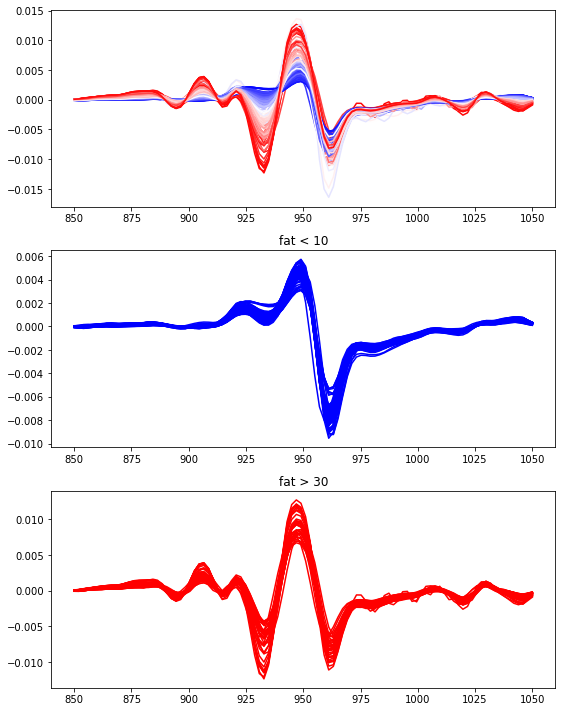

In [1218]:
fig, ax = plt.subplots(3,1, figsize=(8,10))
ax[0].set_prop_cycle('color', list(cm_fat))

for i in range(n_samples):
    ax[0].plot(X, ddab_array[i])

for i in np.where(fat_array<10)[0]:
    ax[1].plot(X, ddab_array[i], c='b')
    ax[1].set_title('fat < 10')

for i in np.where(fat_array>=30)[0]:
    ax[2].plot(X, ddab_array[i], c='r')
    ax[2].set_title('fat > 30')
plt.tight_layout()

## fft des variations ?

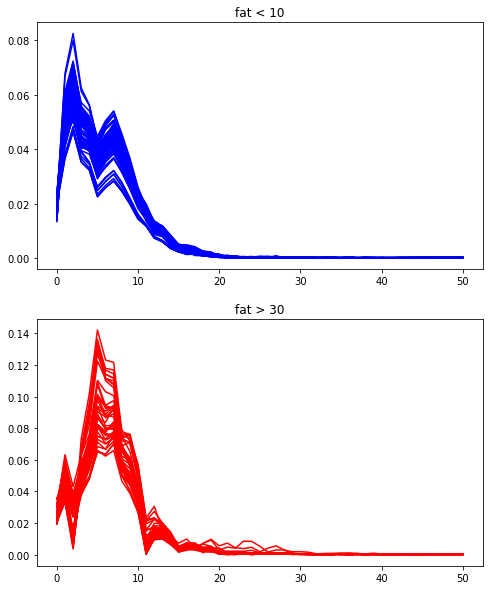

In [1232]:
fft_array = np.abs(np.fft.rfft(ddab_array,axis=-1))

fft_highF = fft_array[fat_array>=30]
fft_lowF = fft_array[fat_array<10]

fig, ax = plt.subplots(2,1, figsize=(8,10))

for s in fft_lowF:
    ax[0].plot(s, c='b')
    ax[0].set_title('fat < 10')
    
for s in fft_highF:
    ax[1].plot(s, c='r')
    ax[1].set_title('fat > 30')

# Simple model: linear regression with L2 regulation

In [ ]:
from sklearn import linear_model

def RMSE(y1, y2):
    return np.sqrt(np.mean((y1-y2)**2))

## based on absorbance spectrum and principal components

### absorbance only

In [1963]:
split_ind = 172

# On ne prend que les valeurs d'absorbance autour de la première bosse
# X_train, Y_train = ab_array[:split_ind,25:50], fat_array[:split_ind]
# X_test, Y_test = ab_array[split_ind:,25:50], fat_array[split_ind:]

# On prend toutes les valeurs
X_train, Y_train = ab_array[:split_ind,:], fat_array[:split_ind]
X_test, Y_test = ab_array[split_ind:,:], fat_array[split_ind:]

# sans les 3 outliers:
# X_train, Y_train = ab_array[:split_ind,:][out_inds[:split_ind]==0], fat_array[:split_ind][out_inds[:split_ind]==0]
# X_test, Y_test = ab_array[split_ind:,:], fat_array[split_ind:]

In [1964]:
alpha_list = [0,1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

minimum test rmse with ridge regression = 2.0
test rmse with linear regression = 3.81
best alpha = 1e-06


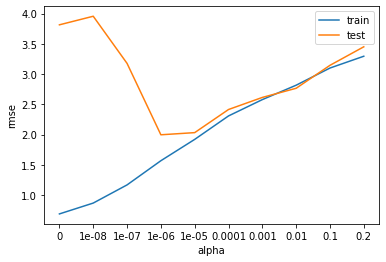

In [1965]:
plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')
print(f'best alpha = {alpha_list[np.argmin(list_score_test)]}')

Test robustesse avec échantillons en moins dans le dataset

std score = 0.11813609206603386


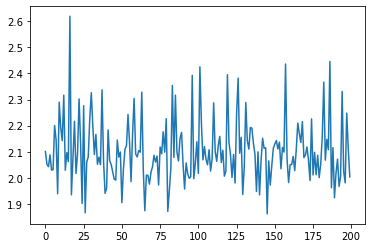

In [1962]:
n_splits = 200
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = linear_model.Ridge(alpha = best_alpha)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

variation de alpha

In [867]:
split_ind = 172
X_train, Y_train = ab_array[:split_ind,:], fat_array[:split_ind]
X_test, Y_test = ab_array[split_ind:,:], fat_array[split_ind:]

n_splits = 5
# training sets with 10 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=10, random_state=0)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

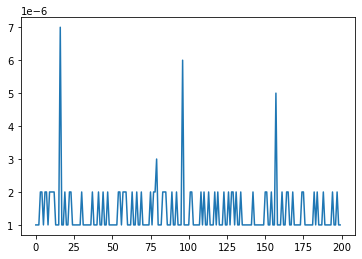

In [1968]:
alpha_list = np.linspace(1e-6,1e-5,10)

best_alpha_list = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]
    
    list_score_test = []
    for a in alpha_list:
        model = linear_model.Ridge(alpha=a)
        model.fit(X_train_cut, Y_train_cut)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train_cut)
        list_score_test.append(RMSE(Y_test, y_pred_test))
        
    best_alpha_list.append(alpha_list[np.argmin(list_score_test)])
        
plt.plot(best_alpha_list)

### absorbance - mean

In [874]:
split_ind = 172
X_train, Y_train = ab_array[:split_ind,:], fat_array[:split_ind]
X_test, Y_test = ab_array[split_ind:,:], fat_array[split_ind:]

X_train = X_train - (X_train.mean(axis=-1)).reshape(len(X_train),1)
X_test = X_test - (X_test.mean(axis=-1)).reshape(len(X_test),1)

In [876]:
alpha_list = [0,1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

minimum test rmse with ridge regression = 2.03
test rmse with linear regression = 4.47


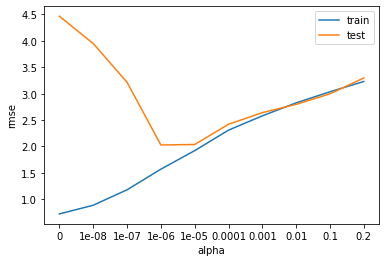

In [877]:
plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

### principal components only

In [1171]:
X_train, Y_train = pc_array[:split_ind], fat_array[:split_ind]
X_test, Y_test = pc_array[split_ind:,:], fat_array[split_ind:]

# sans les outliers:
# X_train, Y_train = pc_array[:split_ind][out_inds[:split_ind]==0], fat_array[:split_ind][out_inds[:split_ind]==0]
# X_test, Y_test = pc_array[split_ind:,:], fat_array[split_ind:]

minimum test rmse with ridge regression = 2.21
test rmse with linear regression = 2.21


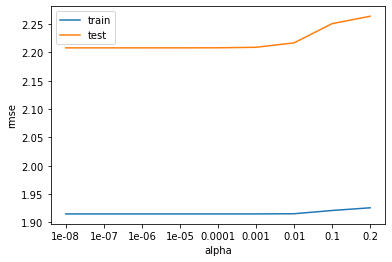

In [1176]:
alpha_list = [1e-8,1e-7,1e-6,1e-5, 1e-4,1e-3,1e-2,0.1,0.2]
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))

plt.plot(list_score_train, label='train')
plt.plot(list_score_test, label='test')
plt.legend()
plt.xticks(range(len(alpha_list)),alpha_list)
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

test rmse on linear regression as a function of last principal component used (numbered between 0 and 21)

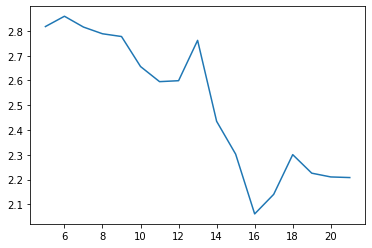

In [648]:
list_score = []
for n_pc in np.arange(5,22)+1:
    X_train, Y_train = pc_array[:split_ind,:n_pc], fat_array[:split_ind]
    X_test, Y_test = pc_array[split_ind:,:n_pc], fat_array[split_ind:]

    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    list_score.append(RMSE(Y_test, y_pred))
    
plt.plot(np.arange(5,22), list_score)

Selection manuelle des composants principaux et test de robustesse

In [1948]:
list_pc = [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,19]
# list_pc = range(22)

X_train, Y_train = pc_array[:split_ind,list_pc], fat_array[:split_ind]
X_test, Y_test = pc_array[split_ind:,list_pc], fat_array[split_ind:]

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
RMSE(Y_test, y_pred)

1.9759384091926955

std score = 0.03653661779593465


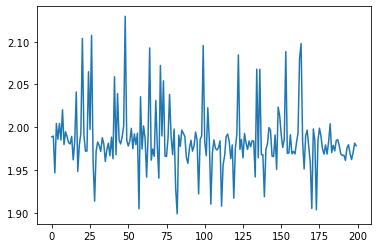

In [1949]:
n_splits = 200
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = linear_model.LinearRegression()
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## Régression linéaire à partir de la FFT de la dérivée seconde

In [1977]:
split_ind = 172

# rmse = 1.6   std = 0.03
# X_train, Y_train = fft_array[:split_ind,:15], fat_array[:split_ind]
# X_test, Y_test = fft_array[split_ind:,:15], fat_array[split_ind:]

# rmse = 1.2   std = 0.06
X_train, Y_train = np.concatenate((ab_array[:split_ind], \
                                   fft_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
X_test, Y_test = np.concatenate((ab_array[split_ind:], \
                                 fft_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]


# X_train, Y_train = np.concatenate((pc_array[:split_ind,:17], \
#                                    fft_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((pc_array[split_ind:,:17], \
#                                  fft_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

# X_train, Y_train = np.concatenate((ab_array[:split_ind,:], \
#                                    pc_array[:split_ind,list_pc], \
#                                    fft_array[:split_ind,:15]), axis=-1), fat_array[:split_ind]
# X_test, Y_test = np.concatenate((ab_array[split_ind:,:], \
#                                   pc_array[split_ind:,list_pc], \
#                                  fft_array[split_ind:,:15]), axis=-1), fat_array[split_ind:]

minimum test rmse with ridge regression = 1.19
test rmse with linear regression = 2.91
best alpha = 4.072072072072072e-07


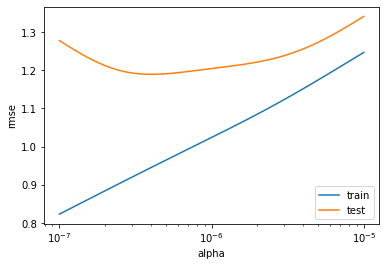

In [1978]:
alpha_list = np.linspace(1e-7,1e-5,1000)
list_score_test = []
list_score_train = []
for a in alpha_list:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))
    
plt.plot(alpha_list, list_score_train, label='train')
plt.plot(alpha_list, list_score_test, label='test')
plt.legend()
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'best alpha = {alpha_list[np.argmin(list_score_test)]}')

std score = 0.06218141378530706


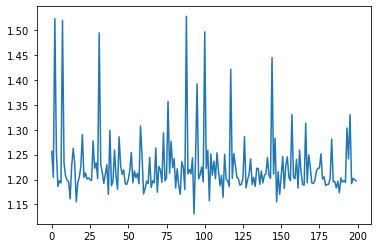

In [1979]:
n_splits = 200
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = linear_model.Ridge(alpha=best_alpha)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## adding PCA of derivatives

minimum test rmse with ridge regression = 1.12
test rmse with linear regression = 2.53
best alpha = 6.846846846846847e-07


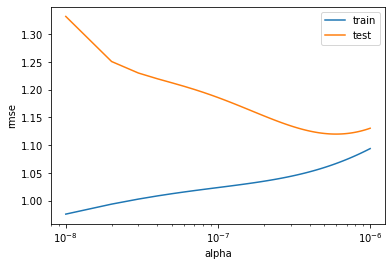

In [1785]:
X_train_ab, X_train_dab, X_train_ddab, Y_train = \
    ab_array[:split_ind,:], dab_array[:split_ind,:], ddab_array[:split_ind,:], fat_array[:split_ind]
X_test_ab, X_test_dab, X_test_ddab, Y_test = \
    ab_array[split_ind:,:], dab_array[split_ind:,:], ddab_array[split_ind:,:], fat_array[split_ind:]

# X_train_fft = fft_array[:split_ind,:15] 
# X_test_fft = fft_array[split_ind:,:15]
X_train_fft = fft_array[:split_ind,:25]  # Combiner avec les pc, le score s'améliore en mettant plus de fréquences
X_test_fft = fft_array[split_ind:,:25]

PCA_ab = sk.decomposition.PCA(n_components=13)
PCA_dab = sk.decomposition.PCA(n_components=23)  #Mettre plus de pc (23) pour la 1ere dérivée améliore le score mais résultat moins robuste
PCA_ddab = sk.decomposition.PCA(n_components=13)

PCA_ab.fit(X_train_ab)
PCA_dab.fit(X_train_dab)
PCA_ddab.fit(X_train_ddab)

X_train_pc, X_train_dpc, X_train_ddpc = \
    PCA_ab.transform(X_train_ab), PCA_dab.transform(X_train_dab), PCA_ddab.transform(X_train_ddab)
X_test_pc, X_test_dpc, X_test_ddpc = \
    PCA_ab.transform(X_test_ab), PCA_dab.transform(X_test_dab), PCA_ddab.transform(X_test_ddab)

# X_train = np.concatenate((X_train_ab, X_train_dpc, X_train_ddpc, X_train_fft), -1)
# X_test = np.concatenate((X_test_ab, X_test_dpc, X_test_ddpc, X_test_fft), -1)

X_train = np.concatenate((X_train_pc, X_train_dpc, X_train_ddpc, X_train_fft), -1)
X_test = np.concatenate((X_test_pc, X_test_dpc, X_test_ddpc, X_test_fft), -1)

# X_train = np.concatenate((X_train_pc, X_train_dpc, X_train_ddpc), -1)
# X_test = np.concatenate((X_test_pc, X_test_dpc, X_test_ddpc), -1)


alphas = np.linspace(1e-8,1e-6,100)
list_score_test = []
list_score_train = []
for a in alphas:
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train, Y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    list_score_test.append(RMSE(Y_test, y_pred_test))
    list_score_train.append(RMSE(Y_train, y_pred_train))
    
plt.plot(alphas, list_score_train, label='train')
plt.plot(alphas, list_score_test, label='test')
plt.xscale('log')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('rmse')

print(f'minimum test rmse with ridge regression = {np.round(np.min(list_score_test),2)}')

model = linear_model.LinearRegression()
model.fit(X_train_pcd, Y_train)
y_pred = model.predict(X_test_pcd)

print(f'test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')
best_alpha = alpha_list[np.argmin(list_score_test)]
print(f'best alpha = {best_alpha}')

std score = 0.1412065270289158


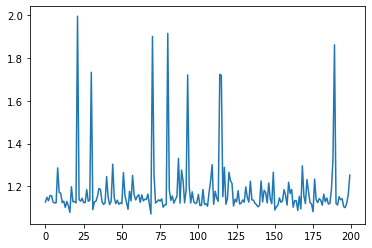

In [1786]:
n_splits = 200
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = linear_model.Ridge(alpha=best_alpha)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## conclusion:

Les résultats obtenus avec absorbance et fft de la dérivée seconde sont les plus robustes

# Try with more advanced models

## Gaussian process

In [1787]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor

In [1980]:
X_train_ab, X_train_dab, X_train_ddab, Y_train = \
    ab_array[:split_ind,:], dab_array[:split_ind,:], ddab_array[:split_ind,:], fat_array[:split_ind]
X_test_ab, X_test_dab, X_test_ddab, Y_test = \
    ab_array[split_ind:,:], dab_array[split_ind:,:], ddab_array[split_ind:,:], fat_array[split_ind:]

X_train_fft = fft_array[:split_ind,:15]
X_test_fft = fft_array[split_ind:,:15]

PCA_ab = sk.decomposition.PCA(n_components=20)
PCA_dab = sk.decomposition.PCA(n_components=20)
PCA_ddab = sk.decomposition.PCA(n_components=20)

PCA_ab.fit(X_train_ab)
PCA_dab.fit(X_train_dab)
PCA_ddab.fit(X_train_ddab)

X_train_pc, X_train_dpc, X_train_ddpc = \
    PCA_ab.transform(X_train_ab), PCA_dab.transform(X_train_dab), PCA_ddab.transform(X_train_ddab)
X_test_pc, X_test_dpc, X_test_ddpc = \
    PCA_ab.transform(X_test_ab), PCA_dab.transform(X_test_dab), PCA_ddab.transform(X_test_ddab)

# X_train = np.concatenate((X_train_dpc, X_train_ddpc, X_train_fft), -1)
# X_test = np.concatenate((X_test_dpc, X_test_ddpc, X_test_fft), -1)

# # le Gaussian process peut vite overfitter avec trop d'inputs: ça marche mieux avec les fft seulement
X_train = X_train_fft
X_test = X_test_fft

In [1981]:
parameters_GS = {'alpha':np.linspace(1e-6,1e-4,20)}
GS = GridSearchCV(GaussianProcessRegressor(), parameters_GS, scoring = 'neg_root_mean_squared_error')

GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')

model = GaussianProcessRegressor(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')
print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'alpha': 1e-06}
test rmse = 0.65
train rmse = 0.58


std score = 0.019296916552042572


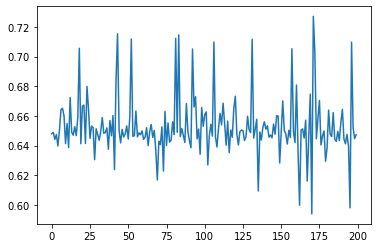

In [1982]:
n_splits = 200
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = GaussianProcessRegressor(**GS.best_params_)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## Kernel Ridge

In [1295]:
from sklearn.kernel_ridge import KernelRidge

In [1996]:
X_train_ab, X_train_dab, X_train_ddab, Y_train = \
    ab_array[:split_ind,:], dab_array[:split_ind,:], ddab_array[:split_ind,:], fat_array[:split_ind]
X_test_ab, X_test_dab, X_test_ddab, Y_test = \
    ab_array[split_ind:,:], dab_array[split_ind:,:], ddab_array[split_ind:,:], fat_array[split_ind:]

X_train_fft = fft_array[:split_ind,:15]
X_test_fft = fft_array[split_ind:,:15]

# 1
# PCA_ab = sk.decomposition.PCA(n_components=20)
# PCA_dab = sk.decomposition.PCA(n_components=20)
# PCA_ddab = sk.decomposition.PCA(n_components=20)

#2
PCA_ab = sk.decomposition.PCA(n_components=13)
PCA_dab = sk.decomposition.PCA(n_components=13)
PCA_ddab = sk.decomposition.PCA(n_components=13)


PCA_ab.fit(X_train_ab)
PCA_dab.fit(X_train_dab)
PCA_ddab.fit(X_train_ddab)

X_train_pc, X_train_dpc, X_train_ddpc = \
    PCA_ab.transform(X_train_ab), PCA_dab.transform(X_train_dab), PCA_ddab.transform(X_train_ddab)
X_test_pc, X_test_dpc, X_test_ddpc = \
    PCA_ab.transform(X_test_ab), PCA_dab.transform(X_test_dab), PCA_ddab.transform(X_test_ddab)

# 1
# X_train = np.concatenate((X_train_pc, X_train_dpc, X_train_ddpc, X_train_fft), -1)
# X_test = np.concatenate((X_test_pc, X_test_dpc, X_test_ddpc, X_test_fft), -1)

#2
# X_train = np.concatenate((X_train_pc, X_train_dpc, X_train_ddpc), -1)
# X_test = np.concatenate((X_test_pc, X_test_dpc, X_test_ddpc), -1)

#3
X_train = X_train_fft
X_test = X_test_fft


#1 et #2 donnent un peu près les mêmes scores sur ce dataset (rmse=0.5), mais #3 est plus robuste

In [2006]:
parameters_GS = {'kernel':['linear','rbf', 'polynomial'],'alpha':np.linspace(1e-10,1e-7,20)}
GS = GridSearchCV(KernelRidge(), parameters_GS, scoring = 'neg_root_mean_squared_error')


GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')

model = KernelRidge(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')
print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'alpha': 1e-10, 'kernel': 'rbf'}
test rmse = 0.5
train rmse = 0.35


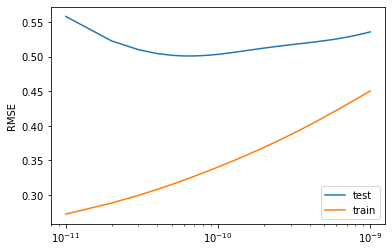

In [2005]:
scores_test = []
scores_train = []
alphas = np.linspace(1e-11,1e-9,100)

for a in alphas:
    model = KernelRidge(alpha = a, kernel = 'polynomial')
    model.fit(X_train, Y_train)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    scores_test.append(RMSE(y_pred_test, Y_test))
    scores_train.append(RMSE(y_pred_train, Y_train))

plt.plot(alphas, scores_test, label='test')
plt.plot(alphas, scores_train, label='train')
plt.xscale('log')
plt.ylabel('RMSE')
plt.legend()

Test robustesse du Kernel Ridge

std score = 0.020086812093965678


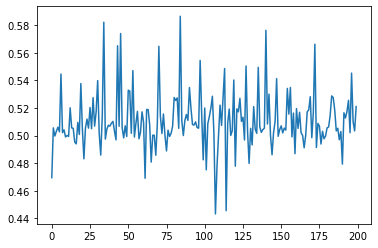

In [2007]:
n_splits = 200
# training sets with 5 sample removed each time
rs = ShuffleSplit(n_splits=n_splits, test_size=5)

rs.get_n_splits(X_train)

train_splits = [s[0] for s in rs.split(X_train)]

score = []
for i in range(n_splits):
    
    X_train_cut, Y_train_cut = X_train[train_splits[i]], Y_train[train_splits[i]]

    model = KernelRidge(**GS.best_params_)
    model.fit(X_train_cut, Y_train_cut)
    y_pred = model.predict(X_test)

    score.append(RMSE(Y_test, y_pred))
#     print(f'split {i} - test rmse with linear regression = {np.round(RMSE(Y_test, y_pred), 2)}')

print(f'std score = {np.std(score)}')
plt.plot(score)

## Forest Regression

In [1868]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [1869]:
from sklearn.model_selection import GridSearchCV

parameters_GS = {'n_estimators':[50,100],'learning_rate':[1e-2,0.05,0.1], 
                 'max_depth':range(1,4)}
# parameters_GS = {'n_estimators':[50,100], 'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 'max_depth':range(1,4)}

In [1870]:
GS = GridSearchCV(GradientBoostingRegressor(), parameters_GS, scoring = 'neg_root_mean_squared_error')
# GS = GridSearchCV(RandomForestRegressor(), parameters_GS, scoring = 'neg_root_mean_squared_error')

GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')
print(f'best score = {GS.best_score_}')

model = GradientBoostingRegressor(**GS.best_params_, alpha = 1e-4)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')
print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
best score = -1.6068489436229458
test rmse = 1.05
train rmse = 0.53


## Small NN

In [1871]:
from sklearn.neural_network import MLPRegressor

In [1945]:
X_train_ab, X_train_dab, X_train_ddab, Y_train = \
    ab_array[:split_ind,:], dab_array[:split_ind,:], ddab_array[:split_ind,:], fat_array[:split_ind]
X_test_ab, X_test_dab, X_test_ddab, Y_test = \
    ab_array[split_ind:,:], dab_array[split_ind:,:], ddab_array[split_ind:,:], fat_array[split_ind:]

X_train_fft = fft_array[:split_ind,:15]
X_test_fft = fft_array[split_ind:,:15]

PCA_ab = sk.decomposition.PCA(n_components=13)
PCA_dab = sk.decomposition.PCA(n_components=13)
PCA_ddab = sk.decomposition.PCA(n_components=13)

PCA_ab.fit(X_train_ab)
PCA_dab.fit(X_train_dab)
PCA_ddab.fit(X_train_ddab)

X_train_pc, X_train_dpc, X_train_ddpc = \
    PCA_ab.transform(X_train_ab), PCA_dab.transform(X_train_dab), PCA_ddab.transform(X_train_ddab)
X_test_pc, X_test_dpc, X_test_ddpc = \
    PCA_ab.transform(X_test_ab), PCA_dab.transform(X_test_dab), PCA_ddab.transform(X_test_ddab)

# 1 0.7
X_train = np.concatenate((X_train_pc, X_train_dpc, X_train_ddpc, X_train_fft), -1)
X_test = np.concatenate((X_test_pc, X_test_dpc, X_test_ddpc, X_test_fft), -1)

#2  0.7
# X_train = np.concatenate((X_train_pc, X_train_dpc, X_train_ddpc), -1)
# X_test = np.concatenate((X_test_pc, X_test_dpc, X_test_ddpc), -1)

#3 1.3
# X_train = X_train_fft
# X_test = X_test_fft

#4  2.72
# X_train = np.concatenate((X_train_ab-X_train_ab[:,0].reshape(-1,1), X_train_fft), -1)
# X_test = np.concatenate((X_test_ab-X_test_ab[:,0].reshape(-1,1), X_test_fft), -1)

#5  0.76
# X_train = np.concatenate((X_train_dab, X_train_fft), -1)
# X_test = np.concatenate((X_test_dab, X_test_fft), -1)


In [1946]:
# X_train = X_train_dab
# X_test = X_test_dab

In [1947]:
parameters_GS = {'alpha':[1e-3],'hidden_layer_sizes':[[100],[200],[100]*2], 'learning_rate_init':[5e-3], 'max_iter':[10000]}
GS = GridSearchCV(MLPRegressor(), parameters_GS, scoring = 'neg_root_mean_squared_error')


GS.fit(X_train, Y_train)

print(f'best params = {GS.best_params_}')

model = MLPRegressor(**GS.best_params_)

model.fit(X_train, Y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(f'test rmse = {np.round(RMSE(y_pred_test, Y_test),2)}')
print(f'train rmse = {np.round(RMSE(y_pred_train, Y_train),2)}')

best params = {'alpha': 0.001, 'hidden_layer_sizes': [200], 'learning_rate_init': 0.005, 'max_iter': 10000}
test rmse = 0.73
train rmse = 0.36


# Réseaux de neurone

In [1602]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

## DNN

In [1603]:
class DNN(nn.Module): 
    def __init__(self,dim_layers,
                 dropout=0.1):
        super().__init__()
        
        self.activ = nn.ReLU()
        
        self.hidden_layers = [nn.Sequential(weight_norm(nn.Linear(i, j)), self.activ, nn.Dropout(dropout)) \
                       for i,j in zip(dim_layers[:-2], dim_layers[1:-1])]
        self.last_layer = [weight_norm(nn.Linear(dim_layers[-2], dim_layers[-1]))]
        self.network = nn.Sequential(*(self.hidden_layers+self.last_layer))

    def forward(self, X):
        output = self.network(X)
        return output

In [1619]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train).float())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(Y_test).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [1620]:
model = DNN(dim_layers = [len(X_train[0]), 10,100,1])

loss_fn = nn.MSELoss()

def T_rmse(Y_pred, Y):
    return torch.sqrt(torch.mean((Y_pred.detach() - Y.detach())**2)).item()

for X,Y in train_loader:
    Y_pred = model(X)
    print(T_rmse(Y_pred, Y.reshape(-1,1)))
    break

27.278146743774414


In [1623]:
LR = 1e-2

loss_fn = nn.MSELoss()

score_train = []
score_test = []

model = DNN(dim_layers = [len(X_train[0]),10,100,10,1], dropout = 0.)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

epoch = 200

for n in range(epoch):
    model.train()
    score = []
    for step, (X,Y) in enumerate(train_loader):
        
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        score.append(T_rmse(Y_pred, Y))
    score_train.append(np.mean(score))
    
    model.eval()
    score = []
    for step, (X,Y) in enumerate(test_loader):
        Y_pred = model(X)
        score.append(T_rmse(Y_pred, Y))
    score_test.append(np.mean(score))

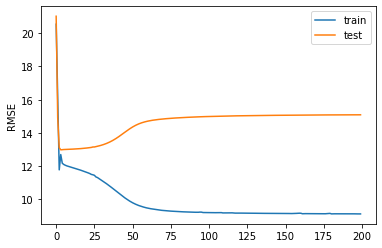

In [1624]:
plt.plot(score_train, label='train')
plt.plot(score_test, label='test')
plt.ylabel('RMSE')
plt.legend()

## Transformer

In [2027]:
import math
class convolution(nn.Module):
    def __init__(self,input_channel, output_channel, kernel_size, dropout=0, batchnorm=True):
        super().__init__()
        self.conv = weight_norm(nn.Conv1d(input_channel, output_channel, kernel_size, padding=1))
        self.relu = nn.PReLU()
        self.drop = nn.Dropout(dropout)
        if batchnorm:
            self.BN = torch.nn.BatchNorm1d(output_channel)
            self.net = nn.Sequential(self.conv, self.BN, self.relu, self.drop)
        else:
            self.net = nn.Sequential(self.conv, self.relu, self.drop)
    def forward(self, X):
        return self.net(X)


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x): # x has size [batch_size, len_seq, d_model]
        pe = torch.cat([self.pe[:x.size(1), :].unsqueeze(0) for n in range(x.size(0))])
        x = x + pe
        return self.dropout(x)


class CNN_transformer(nn.Module):
        def __init__(self, input_channel,\
                 conv_channel, kernel_size,\
                 hidden_linear,\
                 last_dim = 1,\
                 bidirectional = True,\
                 num_transformer = 1, hidden_feedforward = 128, nhead = 1,\
                 last_hidden_pos = None, dropout = 0.1, dropout_cnn = 0., batch_norm = False):
            
            super().__init__()

            self.convolution = convolution(input_channel,conv_channel,kernel_size, dropout=dropout_cnn, batchnorm=batch_norm)

            self.bidirectional = bidirectional
            self.pos_encoder = PositionalEncoding(conv_channel, dropout)
            encoder_layer = nn.TransformerEncoderLayer(conv_channel, nhead, dim_feedforward=hidden_feedforward, dropout=0.1, activation='relu')
            self.transformer = nn.TransformerEncoder(encoder_layer, num_transformer, norm=None)

            self.last_hidden_pos = last_hidden_pos

            self.linear = nn.Linear(conv_channel, last_dim) 

        def forward(self, X):

            output = self.convolution(X.transpose(1,2)).transpose(1,2)

            output = self.pos_encoder(output)

            output = self.transformer(output)

            if self.last_hidden_pos is not None:
                output = output[:,-self.last_hidden_pos:,:].mean(dim=1)
            else:
                output = output.mean(dim=1)

            output = self.linear(output)
            return output

In [2028]:
model = CNN_transformer(1,\
                 128, 3,\
                 128,\
                 last_dim = 1,\
                 bidirectional = True,\
                 num_transformer = 1, hidden_feedforward = 128, nhead = 1,\
                 last_hidden_pos = 12, dropout = 0.1, dropout_cnn = 0., batch_norm = True)

In [2025]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train).float())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test).float(), torch.tensor(Y_test).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

In [2029]:
for X,Y in train_loader:
    Y_pred = model(X)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)